## TODO

- I need to correct the token count
- Complexity
    - add total avg of dataset maybe in chart corner
    - Sort: build sorting in plotting function 
    - Maybe assume: more then 3 solved tasks?
- Take best few models and compare categories?!
- take best few configurations, i.e. best model+repres -> means multiple times GPT 


## Imports

In [1]:
import os
import json
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from adjustText import adjust_text
from tot.methods.arc_utils import load_arc_tasks
import warnings
warnings.filterwarnings("ignore")

## Create log summaries

In [2]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Flatten a nested dictionary. Concatenate keys for nested elements.
    """
    items = []
    for k, v in d.items():
        new_key = f'{parent_key}{sep}{k}' if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif k == "new_representation":
            if v is None:
                items.append((new_key, "0 - 9"))
            elif "." in v:
                items.append((new_key, "'.', 'a' - 'i'"))
            elif "a" in v:
                items.append((new_key, "'a' - 'j'"))

            
        else:
            items.append((new_key, v))
    return dict(items)

def get_avg_solved_task_complexity(tasks_jsons, tasks_names, solved_tasks):  
    # derive complexity = number of pixels in the test input
    complexity = []
    for task_json in tasks_jsons:
        array = np.array(task_json["test"][0]["input"])
        shape = array.shape
        complexity.append(np.prod(shape))

    df = pd.DataFrame({'task_name': tasks_names, 'complexity': complexity})
    
    sum_complexity = 0
    for solved_task in solved_tasks:
        index = np.where(df['task_name'] == solved_task[0])
        sum_complexity += df['complexity'].iloc[index[0][0]]
    if sum_complexity == 0:
        return 0
    return sum_complexity / len(solved_tasks)
    
def read_and_parse_tasks_log(path, save_to_csv=False):
    data = []

    if not os.path.isdir(path):
        print(f"The provided path {path} is not a directory.")
        return pd.DataFrame()
    
    # derive task
    task = path.split("/")[-1]
    # get all tasks
    data_dir = os.path.join("/work/jbriem/repos/master_thesis/tree-of-thought-llm/src/tot/data", task)
    tasks_jsons, tasks_names, _ = load_arc_tasks(data_dir, task)
    
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            log_file = os.path.join(item_path, 'all_tasks_log.json')
            if os.path.isfile(log_file):
                try:
                    with open(log_file, 'r') as file:
                        log_data = json.load(file)[0]  # Read only the first item
                        flattened_data = flatten_dict(log_data)
                        avg_complexity = get_avg_solved_task_complexity(tasks_jsons, tasks_names, flattened_data["solved_tasks"])
                        flattened_data["avg_complexity"] = avg_complexity
                        data.append(flattened_data)
                except Exception as e:
                    print(f"Error reading {log_file}: {e}")
    df = pd.DataFrame(data)
    if save_to_csv:
        df.to_csv(path+"/summary.csv", index=False)
        print("saved to "+path+"/summary.csv")
    return df


In [5]:
path = "/work/jbriem/repos/master_thesis/results/baseline_naive/arc_1D"
data = read_and_parse_tasks_log(path, save_to_csv=True)
#display(data)

Total number of tasks: 901
saved to /work/jbriem/repos/master_thesis/results/baseline_naive/arc_1D/summary.csv


## Plotting functions

In [6]:
def plot_model_performance_across_runs(dataframe, exp_column, score_column, task=""):
    # Filter the relevant columns
    df_filtered = dataframe[['model', exp_column, score_column]]

    # Convert Score to numeric values if they are in percentage format
    if df_filtered[score_column].dtype == object:
        df_filtered[score_column] = df_filtered[score_column].str.rstrip('%').astype('float') / 100.0

    # Step 1 & 2: Group by 'Model' and find the maximum 'Success' value for each group
    group_max = df_filtered.groupby('model')[score_column].max()

    # Step 3: Sort the groups by maximum 'Success' value
    sorted_groups = group_max.sort_values(ascending=False).index.tolist()

    # Step 4 & 5: Sort within each group by 'Representation' and concatenate
    sorted_df = pd.concat([df_filtered[df_filtered['model'] == group].sort_values(by=exp_column) for group in sorted_groups])

    sorted_df.reset_index(drop=True, inplace=True)

    # Set the style for the plots
    plt.style.use('seaborn-darkgrid')

    # add multiplication if not in percentage format
    if score_column == "avg_complexity":
        m = 100
    else: 
        m = 1
        
    # Create a line plot for each model
    tmp_last_y_left = tmp_last_y_right = -999
    for model in sorted_groups:
        model_data = sorted_df[sorted_df['model'] == model]
        line = plt.plot(model_data[exp_column], model_data[score_column], marker='o', label=model.split("/")[-1])
        line_color = line[0].get_color()  # Get the color of the line
        
        # Find the highest score for the model
        max_score = model_data[score_column].max()
        max_score_data = model_data[model_data[score_column] == max_score]
        
        if max_score == 0:
            continue

        # Highlight the highest score for the model
        plt.scatter(max_score_data[exp_column], max_score_data[score_column], color=line_color, s=60, edgecolor='black', zorder=5)
        
        # Check the position of the highest score and adjust the annotation accordingly
        for _, row in max_score_data.iterrows():
            data_point_y = row[score_column]
            if row[exp_column] == model_data[exp_column].iloc[0]:  # If highest score is in the first run
                if data_point_y - tmp_last_y_left < 0.02*m and data_point_y - tmp_last_y_left > -0.02*m:
                    y_annotation_lift_l += -4
                else:
                    y_annotation_lift_l = 0
                plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
                            textcoords="offset points", xytext=(-35,2+y_annotation_lift_l), ha='left')
                tmp_last_y_left = data_point_y
            elif row[exp_column] == model_data[exp_column].iloc[-1]:  # If highest score is in the last run
                if data_point_y - tmp_last_y_right < 0.02*m and data_point_y - tmp_last_y_right > -0.02*m:
                    y_annotation_lift_r += -4
                else:
                    y_annotation_lift_r = 0
                plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
                            textcoords="offset points", xytext=(35,2+y_annotation_lift_r), ha='right')
                tmp_last_y_right = data_point_y
            else:  # For all other cases, put the annotation above the point
                plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
                            textcoords="offset points", xytext=(0,7), ha='center')

    # Adjust margins here by setting x-axis limits
    # Get current axis
    ax = plt.gca()
    # Retrieve the current limits
    xmin, xmax = ax.get_xlim()
    # Set new limits with some padding
    ax.set_xlim(xmin - 0.5, xmax + 0.5)
        
    # Adding legends, labels and title
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel(exp_column)
    plt.ylabel(score_column)
    if task == "arc_1D":
        task_name = "1D ARC - "
    elif task == "arc_h_v":
        task_name = "ARC horizontal vs. vertical - " 
    elif task == "arc":
        task_name = "50 ARC Tasks - "
    else:
        task_name = ""
    
    if score_column == "avg_complexity":
        plt.title(task_name + 'Average Complexity of Models Across different Experiments')
    elif score_column == "success_rate":
        plt.title(task_name + 'Success rate of Models Across different Experiments')
    else:
        plt.title(task_name + 'Performance of Models Across different Experiments')

    # Show the plot
    plt.show()


In [153]:
# For Venn diagramm

def get_overlapping_tasks(data):

    data["solved_tasks"] = [[task[0] for task in tasks] for tasks in data["solved_tasks"]]

    # Create a dictionary to store solved tasks for each model
    model_tasks = {row['model']: set(row['solved_tasks']) for _, row in data.iterrows()}

    result = {}

    # Create combinations of models and find the overlapping tasks for triples
    combinations_triples = list(combinations(data['model'], 3))

    for combination in combinations_triples:
        model1, model2, model3 = combination
        overlapping_tasks = model_tasks[model1].intersection(model_tasks[model2], model_tasks[model3])
        result[f'{model1}-{model2}-{model3}'] = list(overlapping_tasks)

        # Remove overlapping tasks from individual models
        for model in combination:
            model_tasks[model] -= overlapping_tasks

    # Create combinations of models and find the overlapping tasks for pairs
    combinations_pairs = list(combinations(data['model'], 2))

    for combination in combinations_pairs:
        model1, model2 = combination
        overlapping_tasks = model_tasks[model1].intersection(model_tasks[model2])
        result[f'{model1}-{model2}'] = list(overlapping_tasks)

        # Remove overlapping tasks from individual models
        for model in combination:
            model_tasks[model] -= overlapping_tasks

    # For individual models
    for model, tasks in model_tasks.items():
        result[model] = list(tasks)

    return result



gpt-4-1106-preview-gpt-3.5-turbo-1106-mistralai/Mistral-7B-v0.1: ['1']
gpt-4-1106-preview-gpt-3.5-turbo-1106: []
gpt-4-1106-preview-mistralai/Mistral-7B-v0.1: []
gpt-3.5-turbo-1106-mistralai/Mistral-7B-v0.1: []
gpt-4-1106-preview: []
gpt-3.5-turbo-1106: []
mistralai/Mistral-7B-v0.1: []


/tmp/ipykernel_2886940/440948037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["solved_tasks"] = [[task[0] for task in tasks] for tasks in data["solved_tasks"]]


In [158]:
# Group the DataFrame by the "Model" column and find the index of the maximum "Success_rate" within each group
idx = data.groupby('model')['success_rate'].idxmax()
# Extract the rows corresponding to the best "Success_rate" for each model
best_rows = data.loc[idx]
# Sort the best_rows DataFrame by "Success_rate" in descending order
best_rows_sorted = best_rows.sort_values(by='success_rate', ascending=False)
# Select the top 4 rows (i.e., the 4 best models)
top_3_models = best_rows_sorted.head(3)
top_3_models["solved_tasks"]
# Call the function with your DataFrame
result = get_overlapping_tasks(top_3_models)

#Print the result
for model, tasks in result.items():
    print(f'{model}: {len(tasks)}')

gpt-4-1106-preview-gpt-3.5-turbo-1106-mistralai/Mistral-7B-v0.1: 97
gpt-4-1106-preview-gpt-3.5-turbo-1106: 89
gpt-4-1106-preview-mistralai/Mistral-7B-v0.1: 68
gpt-3.5-turbo-1106-mistralai/Mistral-7B-v0.1: 21
gpt-4-1106-preview: 202
gpt-3.5-turbo-1106: 40
mistralai/Mistral-7B-v0.1: 35


In [161]:
top_3_models["success_cnt"]

35    456
2     247
28    221
Name: success_cnt, dtype: int64

# Experiments

## Baseline - Naive

### 1D ARC

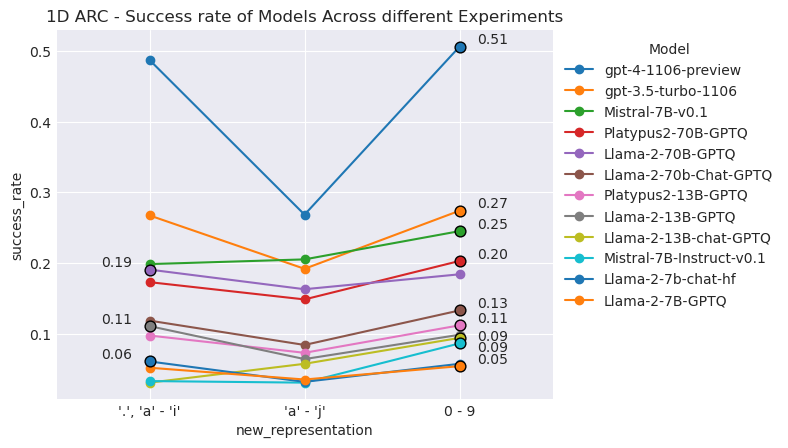

In [7]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline_naive/arc_1D/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_1D")

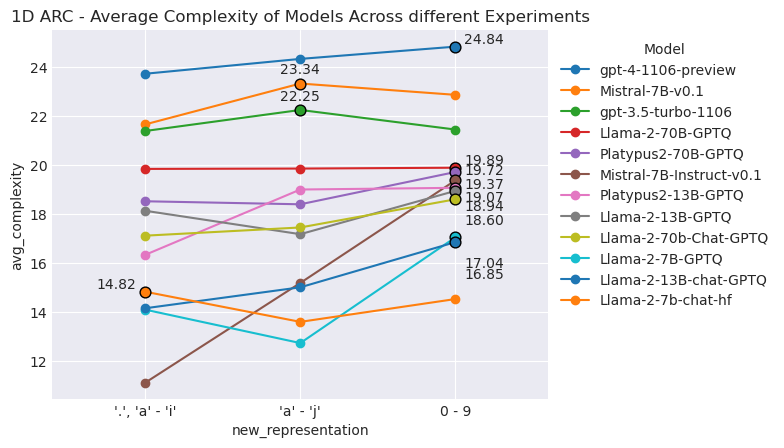

In [8]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline_naive/arc_1D/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc_1D")

### ARC H vs V

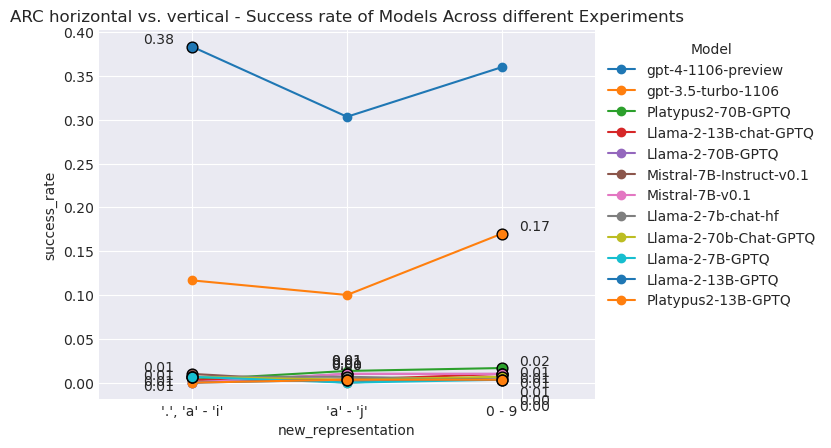

In [9]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline_naive/arc_h_v/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_h_v")

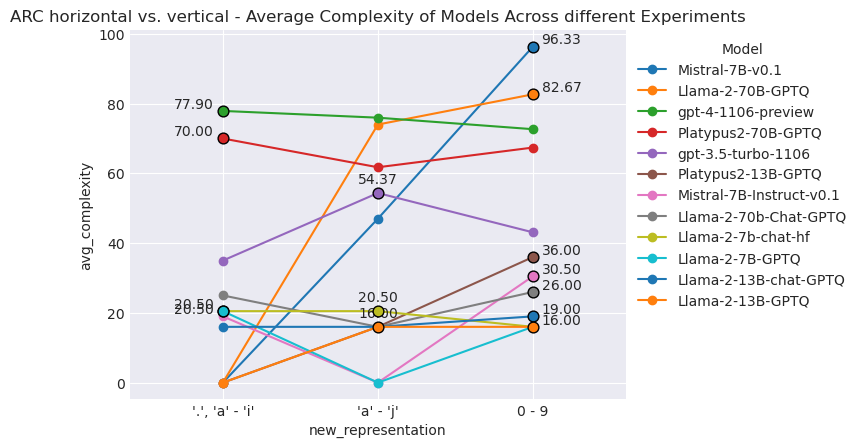

In [10]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline_naive/arc_h_v/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc_h_v")

### ARC original

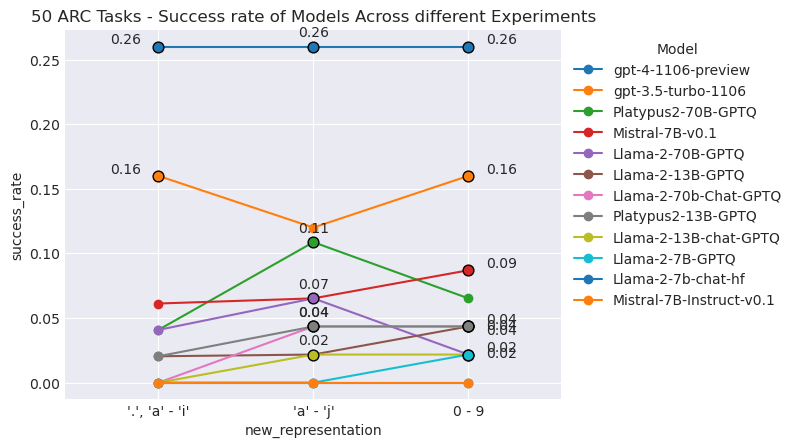

In [11]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline_naive/arc/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc")

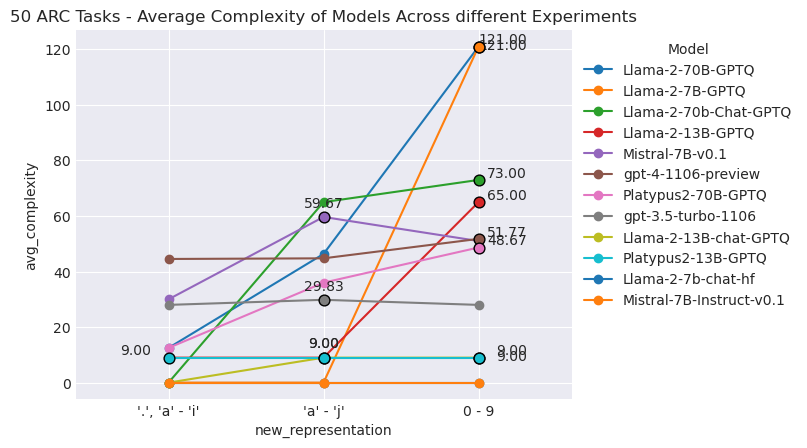

In [12]:
df = pd.read_csv("/work/jbriem/repos/master_thesis/results/baseline_naive/arc/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc")